In [194]:
import os
from os import path as osp
from io import open
from pprint import pprint
import json
from collections import Counter

from bs4 import BeautifulSoup as Soup
from dateutil.parser import parse as parse_datestr
import time

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

In [2]:
ls ide\ project

Data/       Literature/ Submission/


In [3]:
ls ide\ project/Data


anchor posts/         complete forum/
candidate posts/      relevance scores.txt


In [4]:
folder = "ide project/Data/"

In [5]:
files = [ osp.join(folder, 'complete forum', f) for f in os.listdir(osp.join(folder, 'complete forum')) ]

In [10]:
soups = [Soup(open(f).read()) for f in files[1:]]

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html.parser")

  markup_type=markup_type))


In [11]:
print "{} forum files".format(len(soups))

204 forum files


In [12]:
print "{} discussions in all forum files".format(sum([len(soup.forum) for soup in soups]))

20404 discussions in all forum files


In [13]:
# print soups[0].find_all('discussion')[2].prettify()

### What is in the data?

The data is comprised of 205 forum files. Each has about 100 discussions per (20404 discussions in total).

Each discussion has:
* _(property)_ `dcategory` -- a short phrase that describes the topic of the discussion in freetext
* _(property)_ `discussion_id` -- uid of discussion, given the forum
* _(child)_ `dheading` -- display heading of the discussion in freetext
* _(child)_ `dinitiator` -- the username who started the conversation in freetext
* _(child)_ `dtimestamp` -- a timestamp that is absolute but in somewhat noisy freetext
* _(child)_ `text` -- the initial post
    * _(property)_ `postind` -- uid of the post in the discussion
* _(child)_ `posts` -- the actual discussion content posts
    * _(child)_ `post` -- a post in the discussion
        * _(property)_ `postid` -- some id that doesn't make logical sense **IGNORE THIS **
        * _(property)_ `postind` -- the uid of the post used to index the post in the discussion
        * _(property)_ `replied_to` -- the `postind` that this post is in reply to. encodes the tree.
        * _(child)_ `poster` -- the username of the person who created the post. same as `dtimestamp`
        * _(child)_ `timestamp` -- same as `dtimestamp`
        * _(child)_ `text` -- same as `text` above but without the postind property

### What's are some interesting statistics about the posts

In [14]:
flat_discussions = [ d for soup in soups for d in soup.find_all('discussion')]
print "There are {} discussions total".format(len(flat_discussions))

There are 20404 discussions total


In [15]:
flat_posts = [ p for discussion in flat_discussions for p in discussion.find_all('post')]
print "There are {} posts total".format(len(flat_posts))

There are 275714 posts total


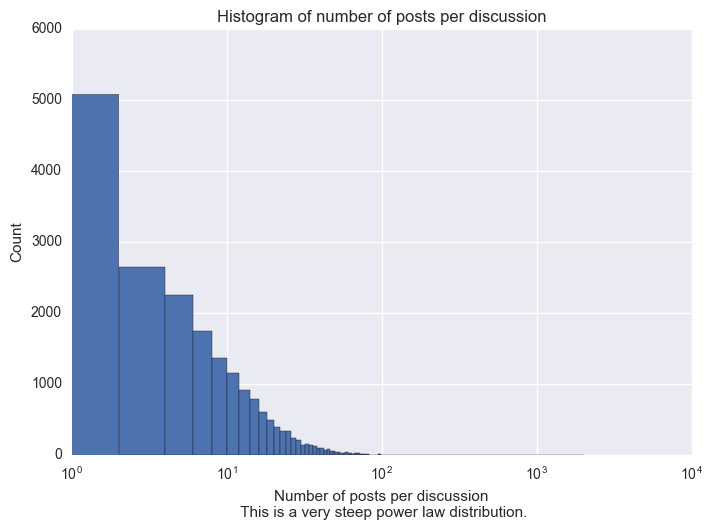

In [16]:
# number of posts per discussion histogram
n_posts_per = [ len(discussion.find_all('post')) for discussion in flat_discussions ]
plt.hist(sorted(n_posts_per), bins=1000)
plt.title('Histogram of number of posts per discussion')
plt.xlabel('Number of posts per discussion\n This is a very steep power law distribution.')
plt.ylabel('Count')
plt.xscale('log')

In [17]:
# number of words per discussion. split on whitespace as proxy for tokens
n_tokens_per = [ len(post.find('text').text.split(' ')) for post in flat_posts ]

(0, 100)

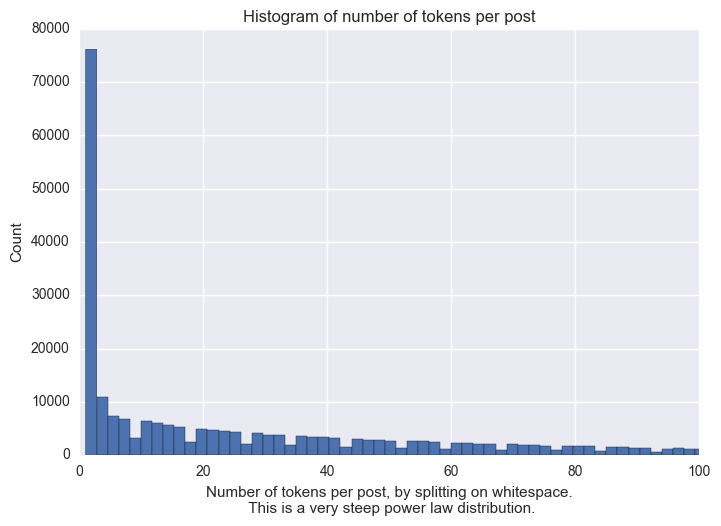

In [18]:
plt.hist(sorted(n_tokens_per), bins=1000)
plt.title('Histogram of number of tokens per post')
plt.xlabel('Number of tokens per post, by splitting on whitespace.\n This is a very steep power law distribution.')
plt.ylabel('Count')
plt.xlim((0,100))

In [19]:
def small_doc(c):
    small_docs = [ n for n in n_tokens_per if n < c]
    print "{}% of the posts have {} or fewer tokens".format(100.*len(small_docs)/len(n_tokens_per), c)
    
for c in [5,10,25,50,100]:
    small_doc(c)

31.5653176843% of the posts have 5 or fewer tokens
37.8638734341% of the posts have 10 or fewer tokens
52.2944065227% of the posts have 25 or fewer tokens
68.1234902834% of the posts have 50 or fewer tokens
85.1792074396% of the posts have 100 or fewer tokens


### Some conclusions

1. Ordinary topic models are not likely to work well here, since there are so few words in most documents
3. As a corrallary, hierarchical models like nHDP wouldn't fare well here either
2. There are a sufficient number of posts that some sort of representation conditioned on the text and metadata could work
3. It could be interesting to use an extractor or gazateers as features

## Preprocess data and output in better format for ML

### Format (json)

The discussions will all be flattened out of the forums.  Each discussion will be normalized so that the initial post will be just another post. Posts that are anchor posts will have an anchor id (unique w/in discussions) (others will be null). All posts will have a field that maps anchor ids to relevance scores, indicating their relevance to an anchor in the discussion.

#### train_data.json

* _(list)_ of discussions
    * _(str)_ `category` -- freetext category of a discussion
    * _(str)_ `heading` -- freetext heading of a discussion
    * _(list)_ `posts` -- all of the posts in the discussion
        * _(int)_ `uid` -- id of post in discussion. Zero is original post. Unique within a discussion
        * _(int)_ `parent_uid` -- id of the post that this post is in reply to. Root post has itself as the parent
        * _(str)_ `user` -- freetext user name for the author of the post
        * _(int)_ `timestamp` -- normalized unix timestamp of the post 
        * _(str)_ `text` -- freetext of the post, not tokenized
            
**NOTE:** Some posts are missing any of category, user, or timestamp, these have been given default values

#### test_data.json

* _(list)_ of discussions
    * _(list)_ `posts` -- all of the posts in a discussion
        * _(int)_ `uid` -- id of post, unique within discussion
        * _(str)_ `text` -- freetext of the post
    * _(list)_ `relevance_scores` -- list of triples of (anchor post id, candidate post id, relevance score)

### Format the training data

In [87]:
def custom_parse_date(element):
    """ Converts all of the weird date strings into a unix timestamp. """
    try:
        datestr = element.text.replace('on ', '').replace(' in', '')
        return int(time.mktime(parse_datestr(datestr).timetuple()))
    except Exception as e:
        return 0

In [89]:
# create the candidate raw data
train_data = []
for i, discussion in enumerate(flat_discussions):
    print "\r{}/{}".format(i+1, len(flat_discussions)),
#     print discussion
#     print 'category {}'.format(discussion['dcategory'])
#     print 'heading {}'.format(discussion.find('dheading').text)
#     print discussion.find('dtimestamp').text
    try:
        category = discussion['dcategory']
    except:
        category = "UNKNOWN"
    try:
        user = discussion.find('dinitiator').text
    except:
        user = "UNKNOWN"
    posts = [{
        'uid':int(discussion.find('text')['postind']),
        'parent_uid':int(discussion.find('text')['postind']),
        'user':user,
        'timestamp':custom_parse_date(discussion.find('dtimestamp')),
        'text':discussion.find('text').text,
        'anchorid': 0,
        'anchor_scores':[]
    }]
#     pprint(first_post)
    for post in discussion.find_all('post'):
        try:
            user = post.find('poster').text
        except:
            user = "UNKNOWN"
        posts.append({
                'uid':int(post['postind']),
                'parent_uid':int(post['replied_to']) if post['replied_to'] else 0,
                'user':user,
                'timestamp':custom_parse_date(post.find('timestamp')),
                'text':post.find('text').text,
                'anchorid': 0,
                'anchor_scores':[]
            })
#         pprint(posts[-1])
    train_data.append({
        'category': category,
        'heading': discussion.find('dheading').text,
        'posts':posts
    })
print "Done"

20404/20404 Done


### Format the test data

In [92]:
# bring in the labeled data (very different formatting)
anchor_soup = Soup(open('ide project/Data/anchor posts/anchor_posts.xml'))
candidate_files = [
    'ide project/Data/candidate posts/discussion_one.xml',
    'ide project/Data/candidate posts/discussion_two.xml',
    'ide project/Data/candidate posts/discussion_three.xml'
]
candidate_soups = [ Soup(open(f)) for f in candidate_files ]

In [223]:
# create an inverted label mapping so we can do ordinal regression.
# before the labels ranged from 01,2,3 with 0 meaning very relevant and 3 meaning very irrelevant...
# this is backwards if we want to maximize a similarity score
# labelmap = {0:3, 1:2, 2:1, 3:0}

# pull out the labels
labels = []
discussion_count = 0
discussion_scores = []
for line in open('ide project/Data/relevance scores.txt').readlines():
    if 'public' in line and ';' in line:
        scores = [ int(s) for s in line.strip().split('{')[1][:-2].split(', ') ]
        discussion_scores.append(scores)
        discussion_count += 1
        if discussion_count % 3 == 0:
            labels.append([ s for s in discussion_scores])
            discussion_scores = []

In [224]:
anchors = [ [ post for post in anchorposts.find_all('anchorpost') ] for anchorposts in anchor_soup.find_all('anchorposts')]
candidates = [ [ post for post in candidate_soup.find_all('candidatepost') ] for candidate_soup in candidate_soups ]

In [225]:
test_data = []
for l, a, c in zip(labels, anchors, candidates):
    posts = [ {'uid':i, 'text':candidate.text} for i, candidate in enumerate(c) ]
    scores = []
    for anchor, anchor_labels in zip(a, l):
        aid = int(anchor['id'])
        for i, label in enumerate(anchor_labels):
            # label id is the index of the candidate post but w/o the candidate id
            # skip over the anchor by adding 1 to the index as soon as we hit it
            lid = i if i < aid else i+1
            scores.append([aid, lid, label])
    test_data.append( {'posts':posts, 'relevance_scores':scores} )

### Write the data out to file

In [226]:
with open('train_data.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(train_data, indent=2, ensure_ascii=False))
with open('test_data.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(test_data, indent=2, ensure_ascii=False))

### What are the label distributions in the test set?

In [227]:
print [len(l) for labs in labels for l in labs]

[32, 32, 32, 39, 39, 39, 47, 47, 47]


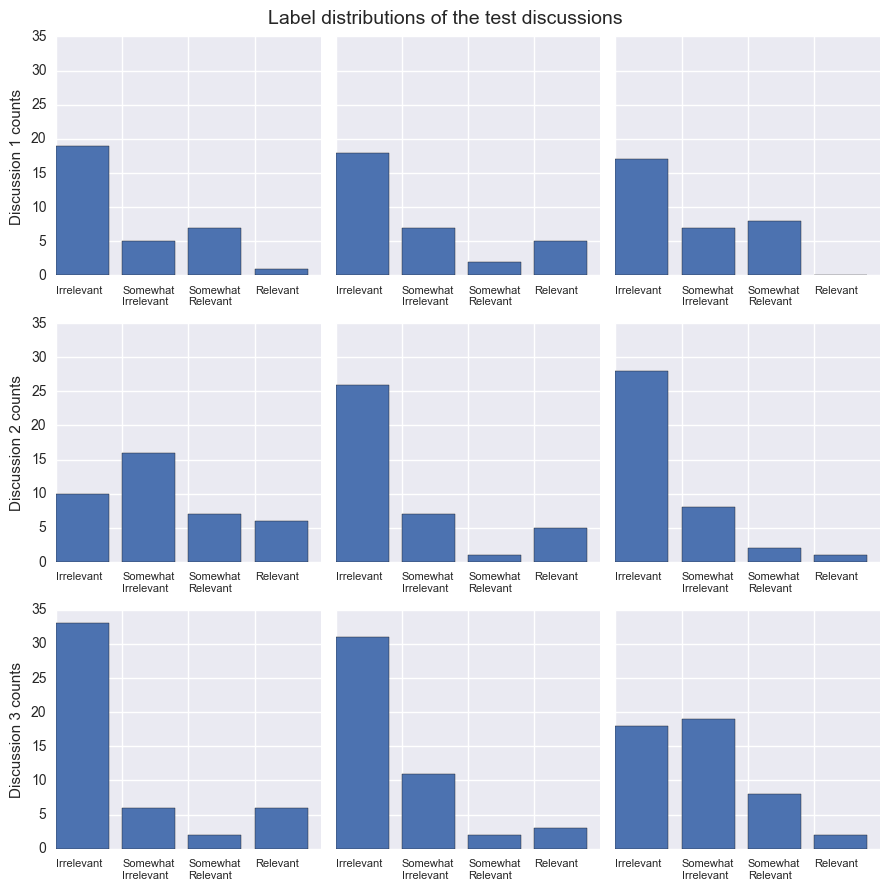

In [228]:
fig, axs = plt.subplots(3,3, figsize=(9,9), sharey=True)
for i, l in enumerate([l for labs in labels for l in labs]):
#     print l
#     print i//3, i%3
#     print sorted(l)
    ls = tuple(range(4))
    counts = Counter({i:0 for i in ls})
    counts.update(l)
    _, cs = zip(*sorted(counts.items(), key=lambda x:x[0]))
    
#     print ls, cs
#     print labels, counts
    ax = axs[i//3, i%3]
    ax.bar(ls, cs)
    ax.set_xticks(ls)
    ax.set_xticklabels(['Irrelevant', 'Somewhat\nIrrelevant', 'Somewhat\nRelevant', 'Relevant'], 
                       ha='left', fontsize=8)
    if i%3 == 0: 
        ax.set_ylabel('Discussion {} counts'.format(i//3+1))
        
fig.suptitle("Label distributions of the test discussions", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)